In [1]:
import osmnx as ox

In [2]:
import numpy as np

In [3]:
from collections import defaultdict

In [4]:
import networkx as nx

In [5]:
from shapely.geometry import Polygon, MultiPolygon

In [6]:
class Name:
    def __init__(self, name: str):
        self.name = name
        
        self.gdf = ox.gdf_from_place(name)
        self.official_name = self.gdf.place_name.values[0]
        self.geometry = self.gdf.geometry[0]
        if not type(self.geometry) is Polygon or type(self.geometry) is MultiPolygon:
            raise TypeError("Location geometry was not a Polygon or a MultiPolygon")
        
    def summary(self):
        print(f"Input Name: {self.name}")
        print(f"Official Name: {self.official_name}")
        print(type(self.geometry))

In [7]:
class Bbox:
    def __init__(self, north, south, east, west):
        self.bbox = (north, south, east, west)
        
    def __iter__(self):
        return (b for b in self.bbox)
    
    def summary(self):
        width = self.bbox[0] - self.bbox[1]
        height = self.bbox[2] - self.bbox[3]
        area = width * height
        print(f"Width: {width}")
        print(f"Height: {height}")
        print(f"Area: {area}")

In [8]:
class NodesGeometry:
    def __init__(self, G, nodes, segments):
        self.segments = segments
        nodes_xy = self.create_nodes_xy(G, nodes)
        nodes_xy = self.update_nodes_xy(nodes_xy, segments)
        self.nodes = self.create_nodes(nodes_xy)
    
    def create_nodes_xy(self, G, nodes):
        nodes_xy = {}
        for node in nodes:
            xy = G.nodes()[node[0]]
            x = xy['x']
            y = xy['y']
            nodes_xy[node] = np.array((x,y))
            
        return nodes_xy
    
    def update_nodes_xy(self, nodes_xy, segments):
        dist = .00001 #change to 10 feet once you figure out units
        for segment in segments:
            if segment[2]['has_comp']:
                unit_vec = self.segment_unit_vec(nodes_xy, segment)
                perp_vec = np.array([unit_vec[1],unit_vec[0]*-1])
                nodes_xy[segment[0]] = nodes_xy[segment[0]] + ((unit_vec * dist) + (perp_vec * dist / 2))
                nodes_xy[segment[1]] = nodes_xy[segment[1]] - ((unit_vec * dist) - (perp_vec * dist / 2))
            else:
                nodes_xy[segment[0]] = nodes_xy[segment[0]] + (unit_vec * dist)
                nodes_xy[segment[1]] = nodes_xy[segment[1]] - (unit_vec * dist)
    
        return nodes_xy

    def xy_vec(self, nodes_xy, n1, n2):
        """
        Calculates the vector that takes you from n1 to n2
        """
        return nodes_xy[n2] - nodes_xy[n1]

    def segment_vec(self, nodes_xy, segment):
        return self.xy_vec(nodes_xy, segment[0], segment[1])

    def segment_unit_vec(self, nodes_xy, segment):
        arr = self.segment_vec(nodes_xy, segment)
        return arr / np.linalg.norm(arr)
    
    def create_nodes(self, nodes_xy):
        nodes_graph = {}
        for k,v in nodes_xy.items():
            nodes_graph[k] = {'x':v[0], 'y':v[1]}
        nodes = [(k, v) for k, v in nodes_graph.items()]
        return nodes

In [9]:
class IntersectionBuilder:
    def __init__(self, in_out):
        """
        :param in_out: in out dictionary of the init_map nodes
        """
        self.intersections = self.create_intersections(in_out)
    
    def create_intersections(self, in_out):
        intersections = []
        for k, v in in_out.items():
            # every in connects to every out - unless same node
            for n_in in v['in']:
                n1 = (k, n_in, 'in')
                for n_out in v['out']:
                    n2 = (k, n_out, 'out')
                    if n_in != n_out:
                        intersections.append((n1, n2, {'type':'intersection'}))
        return intersections

In [10]:
class SegmentBuilder:
    def __init__(self, in_out):
        """
        :param in_out: in out dictionary of the init_map nodes
        """
        self.segments = self.create_segments(in_out)
        self.nodes = self.extract_nodes(self.segments)
    
    def extract_nodes(self, segments):
        nodes = set()
        for segment in segments:
            nodes.add(segment[0])
            nodes.add(segment[1])
        return nodes
        
    def complement_dir(self, s: str):
        """
        TODO: Switch to True and False so I don't have to write this function
        """
        if s == 'in':
            return 'out'
        elif s == 'out':
            return 'in'
        else:
            print("complement_dir failed")
            
    def complement_segment(self, segment):
        """
        Computes the complementary segment of the given segment. The
        complementary segement represents the other direction in a two
        way street.
        """
        n0 = segment[0]
        n1 = segment[1]

        n3 = (n0[0], n0[1], self.complement_dir(n0[2]))
        n2 = (n1[0], n1[1], self.complement_dir(n1[2]))

        return (n2, n3)
    
    def create_segments_set(self, in_out):
        segments_set = set()
        for k, v in in_out.items():
            for node in v['in']:
                n1 = (node, k, 'out')
                n2 = (k, node, 'in')
                segments_set.add((n1, n2))
        return segments_set
    
    def create_segments_list(self, segments):
        segment_list = []
        for segment in segments:
            if (self.complement_segment(segment) in segments):
                has_comp = True
            else:
                has_comp = False
            segment_list.append((segment[0], segment[1], {'type': 'segment', 'has_comp':has_comp}))
        return segment_list
    
    def create_segments(self, in_out):
        segments_set = self.create_segments_set(in_out)
        segments_list = self.create_segments_list(segments_set)
        return segments_list

In [11]:
class Graph:
    """
    A wrapper for nxgraphs that we should probably have
    
    Allows conversions between MultiDiGraphs (visualization) and
    DiGraphs (A*)
    """
    pass

In [12]:
class GraphBuilder:
    def __init__(self, bound):
        """
        The "run" function to make Graph objects
        
        :param bound: user desired bounds of the graph 
        :type bound: Name or Bbox
        
        TODO: Make into callable function that returns a Graph object
        TODO: Figure out what should be saved as an attribute and what should be temp
        """
        self.bound = bound
        self.init_map = self.initialize_map(self.bound)
        self.in_out = self.create_in_out_dict(self.init_map)
        segmentBuilder = SegmentBuilder(self.in_out)
        self.segments = segmentBuilder.segments
        nodes = segmentBuilder.nodes
        self.nodes = NodesGeometry(self.init_map, nodes, self.segments).nodes
        self.intersections = IntersectionBuilder(self.in_out).intersections
        self.edges = self.create_edges(self.segments, self.intersections)
        self.G = self.create_graph()
    
    def initialize_map(self, bound):
        """
        initialize_map takes in a bound and uses osmnx to create an inital
        map of the desired area.
        
        :param bound: user desired bounds of the graph 
        :type bound: Name or Bbox
        """
        init_map = None
        if type(bound) is Name:
            init_map = ox.graph_from_place(bound.official_name)
        elif type(bound) is Bbox:
            init_map = ox.graph_from_bbox(*bbox)
        else:
            raise RuntimeError("Could not create graph from specified bound")
        return init_map
                
    def create_in_out_dict(self, G):
        """
        Creates a dictionary where each key is a node in a graph whos value
        corresponds to the another dictionary that tells what nodes can be traversed
        to by following edges "out" of the key node and what edges lead "in" to the key
        node by following directed edges
        
        :param G: input graph whos nodes and edges are used to create in_out dict
        :type G: MultiDiGraph
        """
        def make_dict():
            return {'in':[],'out':[]}

        in_out = defaultdict(make_dict)
        for start, end in G.edges():
            if start == end:
                continue
            in_out[end]['in'].append(start)
            in_out[start]['out'].append(end)
        return in_out
                        
    def create_edges(self, segments, intersections):
        edges = segments + intersections
        edges = [(u,v,0,d) for u,v,d in edges]
        return edges
    
    def create_graph(self):
        G = nx.MultiDiGraph()
        G.graph = {'name': 'Test Graph','crs': {'init': 'epsg:4326'},'simplified': True}
        G.add_nodes_from(self.nodes)
        G.add_edges_from(self.edges)
        return G
    
    def plot_graph(self, fig_height=10):
        ox.plot_graph(self.G, fig_height=fig_height)
        
    def plot_map(self, fig_height=10):
        """
        Helper function to the initial 
        """
        ox.plot_graph(self.init_map, fig_height=fig_height)
        
    def save(self, filepath):
        """
        Pickle graph object to a file
        
        :param filepath: filepath to save the object
        :type filepath: string
        :rtype: Graph
        """
        pass
    
    def load(self, filename):
        """
        Unpickle a graph object
        
        :param filepath: filepath to the object
        :type filepath: string
        :rtype: Graph
        """
        pass

In [13]:
bbox = Bbox(38.88300016, 38.878726840000006, -77.09939832, -77.10500768)

In [14]:
GB = GraphBuilder(bbox)

UnboundLocalError: local variable 'unit_vec' referenced before assignment

In [ ]:
class MapLoader:
    def __init__(self):
        

In [ ]:
bbox = (38.88300016, 38.878726840000006, -77.09939832, -77.10500768)

In [15]:
bbox_graph = ox.graph_from_bbox(*bbox)

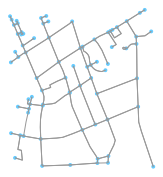

In [16]:
ox.plot_graph(bbox_graph, fig_height=3);

In [ ]:
name = Name("Needham, MA")